In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P1')

Mounted at /content/drive


**Happy Customers.**

A fast growing startup in the logistics and delivery domain wants to predict what makes their customers **happy** or **unhappy**, so they can then take necessary actions.

The company provides us with a small dataset coming from 6 questions they asked their costumers. Getting feedback from customers is not easy either. Thus, the company is also interested in finding out whether they need to ask all 6 questions or there are some they can omit.

**Import libraries.**

In [130]:
## Import libraries

##random
import random

## data
import numpy as np
import pandas as pd

## visualisations
import seaborn as sns
import matplotlib.pyplot as plt


## ignore warnings
import warnings
warnings.filterwarnings("ignore",module = "matplotlib\..*")

## sklearn
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix,classification_report,PrecisionRecallDisplay
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

## basic models
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

## shap
!pip install shap
import shap



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load the data.**

In [163]:
## Load data
data = pd.read_csv('ACME-HappinessSurvey2020.csv')
#data = data.drop('Unnamed: 0',axis=1)
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


**Data Description:**

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

**Let's get some basic information abour our dataset.**

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


- Shape: 126x7
- Data types : correct
- 0 Null values

**Let's change the col. names to something more meaningful and get some statistics.**

In [165]:
## Let's change the col. names to something more meaningful
data.rename(columns={'X1':'delivered_on_time', 
                     'X2':'contents_as_expected',
                     'X3':'ordered_everything_I_wanted',
                     'X4':'paid_a_good_price',
                     'X5':'satisfied_with_my_courier',
                     'X6':'app_makes_ordering_easy',
                     'Y':'Happy'},inplace=True)

## Let's get some statistics
data.describe()

,Happy,delivered_on_time,contents_as_expected,ordered_everything_I_wanted,paid_a_good_price,satisfied_with_my_courier,app_makes_ordering_easy
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


- Values are in the correct range ---> Features (0-5), Target {0,1}

**Let's now take a closer look at our data, starting with the distribution of each feature and their correlation.**

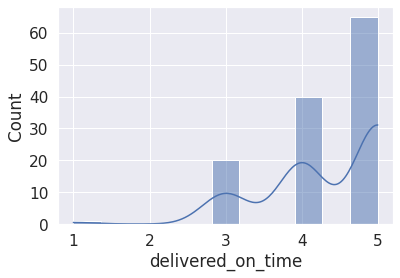

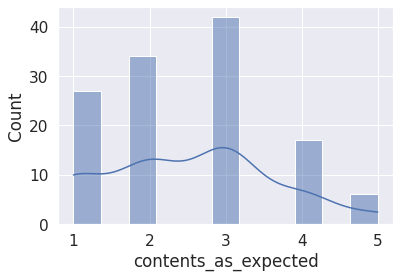

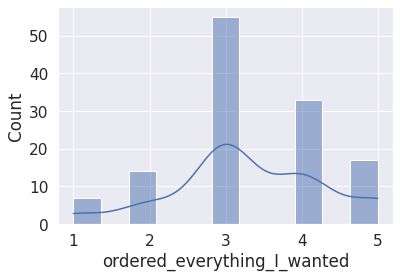

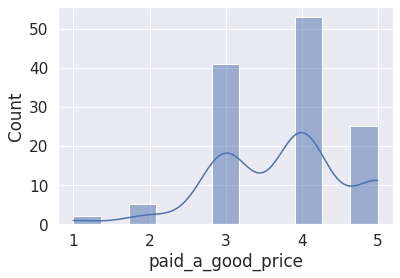

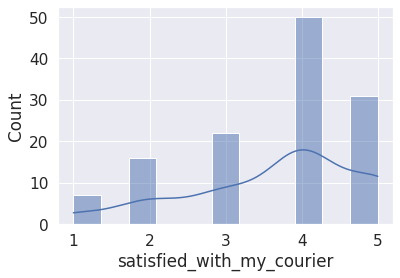

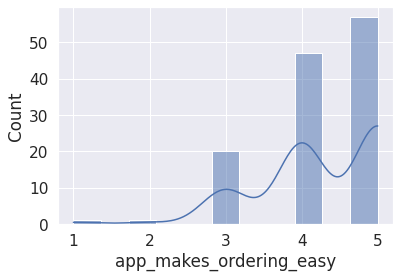

In [166]:
## distributions
for col in data.columns[1:]:
  plt.figure()
  sns.histplot(data=data, x=col, kde=True)

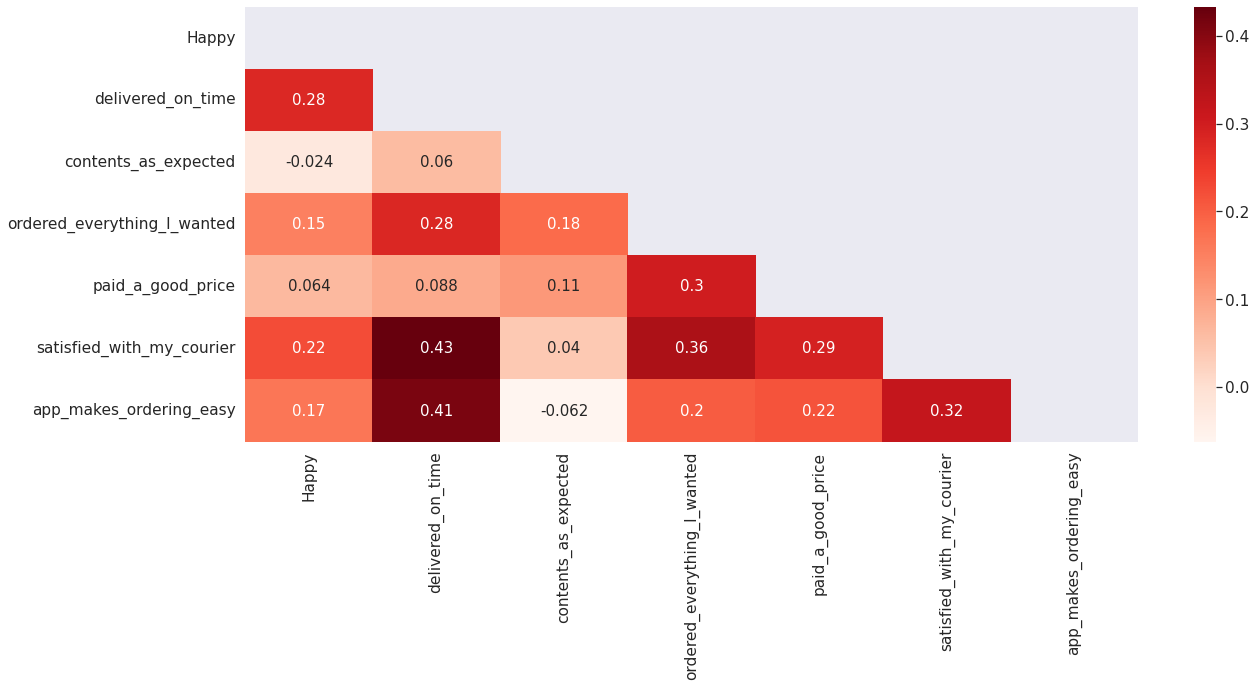

In [167]:
## Correlation Heatmap

sns.set(font_scale=1.4)
# correlation 
cor = data.corr('pearson')
matrix = np.triu(cor)

# heatmap to visualise the correlation
plt.figure(figsize=(20,8))
sns.heatmap(cor,annot=True, cmap=plt.cm.Reds, mask=matrix,annot_kws={'size': 15})
plt.show()

Positively correlated (cor.coeff. > .3=threshold):
  - delivered_on_time with app_makes_ordering_easy and satisfied_with_my_courier
  - ordered_everything_I_wanted with paid_a_good_price and    satisfied_with_my_courier
  - app_makes_ordering_easy with satisfied_with_my_courier

Note:
  - The target variable (Happy) is (+vely)correlated the most with delivered_on_time and satisfied_with_my_courier.

**For each feature let's see how many people gave what rate and what percentage was happy.**

In [136]:
print('Contents as expected:')
print(data['contents_as_expected'].value_counts())
print()
## Is having the contents I wanted delivered enough to be happy? 
per1 = data[(data['contents_as_expected']>=4) & (data['Happy']==1)].shape[0] / (17+6) * 100
per11 = data[(data['contents_as_expected']==3) & (data['Happy']==1)].shape[0] / (42) * 100
per12 = data[(data['contents_as_expected']<=2) & (data['Happy']==1)].shape[0] / (34+27) * 100

print(f'{round(per1,2)}% of those who gave a 4 or a 5 were happy.')
print(f'{round(per11,2)}% of those who gave a 3 were happy.')
print(f'{round(per12,2)}% of those who gave a 2 or a 1 were happy.')

Contents as expected:
3    42
2    34
1    27
4    17
5     6
Name: contents_as_expected, dtype: int64

47.83% of those who gave a 4 or a 5 were happy.
54.76% of those who gave a 3 were happy.
57.38% of those who gave a 2 or a 1 were happy.


In [137]:
print('Delivered on time:')
print(data['delivered_on_time'].value_counts())
print()
## Is delivering on time enough to be happy? 
per2 = data[(data['delivered_on_time']>=4) & (data['Happy']==1)].shape[0] / (40+65) * 100
per21 = data[(data['delivered_on_time']==3) & (data['Happy']==1)].shape[0] / (20) * 100

print(f'{round(per2,2)}% of those who gave a 4 or a 5 were happy.')
print(f'{round(per21,2)}% of those who gave a 3 were happy.')

Delivered on time:
5    65
4    40
3    20
1     1
Name: delivered_on_time, dtype: int64

58.1% of those who gave a 4 or a 5 were happy.
40.0% of those who gave a 3 were happy.


- Note: Nobody gave a 2. 

In [138]:
print('Satisfied with courier:')
print(data['satisfied_with_my_courier'].value_counts())
print()
## Is being satisfied with my courier enough to be happy?
per3 = data[(data['satisfied_with_my_courier']>=4) & (data['Happy']==1)].shape[0] / (50+31) * 100
per31 = data[(data['satisfied_with_my_courier']==3) & (data['Happy']==1)].shape[0] / (22) * 100
per32 = data[(data['satisfied_with_my_courier']<=2) & (data['Happy']==1)].shape[0] / (16+7) * 100

print(f'{round(per3,2)}% of those who gave a 4 or a 5 were happy.')
print(f'{round(per31,2)}% of those who gave a 3 were happy.')
print(f'{round(per32,2)}% of those who gave a 2 or a 1 were happy.')

Satisfied with courier:
4    50
5    31
3    22
2    16
1     7
Name: satisfied_with_my_courier, dtype: int64

61.73% of those who gave a 4 or a 5 were happy.
45.45% of those who gave a 3 were happy.
39.13% of those who gave a 2 or a 1 were happy.


In [139]:
print('Paid a good price:')
print(data['paid_a_good_price'].value_counts())
print()
per4 = data[(data['paid_a_good_price']>=4) & (data['Happy']==1)].shape[0] / (53+25) * 100
per41 = data[(data['paid_a_good_price']==3) & (data['Happy']==1)].shape[0] / (41) * 100
per42 = data[(data['paid_a_good_price']<=2) & (data['Happy']==1)].shape[0] / (5+2) * 100

print(f'{round(per4,2)}% of those who gave a 4 or a 5 were happy.')
print(f'{round(per41,2)}% of those who gave a 3 were happy.')
print(f'{round(per42,2)}% of those who gave a 2 or a 1 were happy.')

Paid a good price:
4    53
3    41
5    25
2     5
1     2
Name: paid_a_good_price, dtype: int64

57.69% of those who gave a 4 or a 5 were happy.
51.22% of those who gave a 3 were happy.
42.86% of those who gave a 2 or a 1 were happy.


In [140]:
print('Ordered everything I wanted:')
print(data['ordered_everything_I_wanted'].value_counts())
print()
per5 = data[(data['ordered_everything_I_wanted']>=4) & (data['Happy']==1)].shape[0] / (33+17) * 100
per51 = data[(data['ordered_everything_I_wanted']==3) & (data['Happy']==1)].shape[0] / (55) * 100
per52 = data[(data['ordered_everything_I_wanted']<=2) & (data['Happy']==1)].shape[0] / (7+14) * 100

print(f'{round(per5,2)}% of those who gave a 4 or a 5 were happy.')
print(f'{round(per51,2)}% of those who gave a 3 were happy.')
print(f'{round(per52,2)}% of those who gave a 2 or a 1 were happy.')

Ordered everything I wanted:
3    55
4    33
5    17
2    14
1     7
Name: ordered_everything_I_wanted, dtype: int64

66.0% of those who gave a 4 or a 5 were happy.
47.27% of those who gave a 3 were happy.
47.62% of those who gave a 2 or a 1 were happy.


In [141]:
print('App makes ordering easy:')
print(data['app_makes_ordering_easy'].value_counts())
print()
per6 = data[(data['app_makes_ordering_easy']>=4) & (data['Happy']==1)].shape[0] / (47+57) * 100
per61 = data[(data['app_makes_ordering_easy']==3) & (data['Happy']==1)].shape[0] / (20) * 100
per62 = data[(data['app_makes_ordering_easy']<=2) & (data['Happy']==1)].shape[0] / (2) * 100

print(f'{round(per6,2)}% of those who gave a 4 or a 5 were happy.')
print(f'{round(per61,2)}% of those who gave a 3 were happy.')
print(f'{round(per62,2)}% of those who gave a 2 or a 1 were happy.')

App makes ordering easy:
5    57
4    47
3    20
2     1
1     1
Name: app_makes_ordering_easy, dtype: int64

59.62% of those who gave a 4 or a 5 were happy.
30.0% of those who gave a 3 were happy.
50.0% of those who gave a 2 or a 1 were happy.


**Check for imbalanced data.**

0.5476190476190477


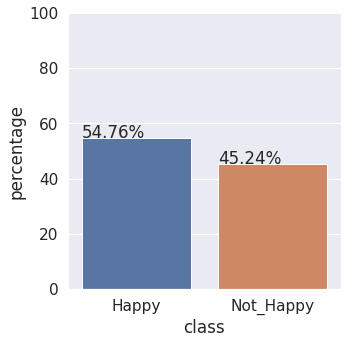

In [142]:
## Check for imbalanced data
df_ = data['Happy'].value_counts(normalize=True)
df_ = df_.mul(100)
df_ = df_.rename('percentage').reset_index()
df_['class'] = ['Happy','Not_Happy']
g = sns.catplot(x='class',y='percentage',kind='bar',data=df_)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

print(sum(data['Happy'])/data['Happy'].shape[0])

- Our data seems to be quite balanced.

Overall:
 
 - Clean data.
 - Balanced data. 

**Build a model for predictions.**

First, we create some basic models using the lazypredict library. 
  - Try different random states.
  - Create dictionary with the best model and its accuracy for each random state.

In [143]:
## split the data frame into the response variable, y, and the design matrix, X
df = data.copy()
y = df['Happy'] ## response 
X = df.drop('Happy',axis=1) ## design matrix


## split the data into training and test data sets
## use different random states
p = pd.DataFrame(columns=['Random_State','Model','Accuracy'])
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                        y, ## response to split
                                                        test_size=0.2, ## we will leave 20% to test our models on later. 
                                                        random_state=i, ## make our work reproducible
                                                       # shuffle=True,  ## prevent data ordering affecting our models
                                                        stratify = y)  ## same amount of ppl who are/are not happy in the training and test set

    basic_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = basic_clf.fit(X_train, X_test, y_train, y_test)
    best_models = models.sort_values(by=['Accuracy'], ascending=False).index.tolist()
    acc = models.sort_values(by=['Accuracy'], ascending=False)['Accuracy'].iloc[0]
    p = p.append({'Random_State': i, 'Model' : best_models[0], 'Accuracy' : acc}, ignore_index=True)

100%|██████████| 29/29 [00:00<00:00, 36.20it/s]


In [144]:
p.sort_values(by=['Accuracy'], ascending=False)[:10]

,Random_State,Model,Accuracy
98,98,BaggingClassifier,0.92
58,58,NearestCentroid,0.81
89,89,BernoulliNB,0.81
74,74,NearestCentroid,0.77
97,97,ExtraTreeClassifier,0.77
33,33,DecisionTreeClassifier,0.77
56,56,PassiveAggressiveClassifier,0.77
40,40,XGBClassifier,0.77
27,27,BernoulliNB,0.77
5,5,ExtraTreeClassifier,0.77


Let's choose the top models based on accuracy to test them on the test dataset.

In [145]:
def top_models(model):
  if model == 'BaggingClassifer':
     cl = BaggingClassifier(random_state=98)
  elif model == 'RandomForestClassifier':
     cl = RandomForestClassifier(random_state=6)
  elif model == 'NearestCentroid':
     random.seed(58)
     cl = NearestCentroid()
  elif model == 'BernoulliNB':
     random.seed(89)
     cl = BernoulliNB()
  elif model == 'ExtraTreesClassifier':
     cl = ExtraTreesClassifier(random_state=97)
  elif model == 'DecisionTreeClassifier':
     cl = DecisionTreeClassifier(random_state=33)
 
  cl.fit(X_train,y_train)
  acc = cl.score(X_test,y_test)
  return 'Accuracy of ' + model + ': ' + str(acc)

In [146]:
models = ['BaggingClassifer',
          'RandomForestClassifier',
          'NearestCentroid',
          'BernoulliNB',
          'ExtraTreesClassifier',
          'DecisionTreeClassifier']
for model in models:
  print(top_models(model))

Accuracy of BaggingClassifer: 0.46153846153846156
Accuracy of RandomForestClassifier: 0.6153846153846154
Accuracy of NearestCentroid: 0.5
Accuracy of BernoulliNB: 0.5384615384615384
Accuracy of ExtraTreesClassifier: 0.5384615384615384
Accuracy of DecisionTreeClassifier: 0.5


The **RandomForestClassifier** performs better than the other models on the test dataset, so we will continue with it.

In [147]:
## split the data frame into the response variable, y, and the design matrix, X
df = data.copy()

y = df['Happy'] ## response 
X = df.drop('Happy',axis=1) ## design matrix

# split the data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.2, ## we will leave 10% to test our models on later. We have a small dataset so we need as many data to train on as possible.
                                                    random_state=6, ## make our work reproducible
                                                   # shuffle=True,  ## prevent data ordering affecting our models
                                                    stratify = y)  ## same amount of ppl who are/are not happy in the training and test set

In [148]:
rf_hyperparams = {"rf__n_estimators": [10,15,20,25,30,35,40,45,50,70,80,90,100,500], ## number of trees used in random forest
                 "rf__max_depth": [2,3,4,5,6,7,9,10,11,14,16,18,20,30,35,40,50], ## max depth 
                 "rf__criterion": ["gini", "entropy"], ## to check whether impurity or information gain is the best way to split
                 "rf__min_samples_leaf": [2,3,4,5,6,7,8,9,10], ## minimum samples beyond which a node cannot be split
                 "rf__max_features": ["sqrt", "log2"], ## to check what is the best way to limit the number of features to each tree
                 "rf__bootstrap": [True,False] ## to check whether bagging and aggregating results in a better model 
                 } 

## SCORING METRICS

f1_score = make_scorer(f1_score, average="weighted") ## F1-score
precision = make_scorer(precision_score, average="weighted") ## Precision
bal_acc_score = make_scorer(balanced_accuracy_score) ## Balanced Accuracy
recall = make_scorer(recall_score, average = "weighted") ## Recall

## storing the scoring metrics to use them later as the strategy of evaluating performance.
scoring_dict = {"bal_acc_score": bal_acc_score,
            "f1_wtd": f1_score,
            "pr_wtd": precision,
            "recall_wtd": recall}


In [149]:
## Randomized Search Cross Validation

pipe = Pipeline([("rf", RandomForestClassifier())])
rscv = RandomizedSearchCV(estimator=pipe,    ## estimator
                    param_distributions=rf_hyperparams, ## parameters to try
                    scoring = scoring_dict,  ## strategy to evaluate performance of the cross-validated model on the test set.
                    refit = "bal_acc_score", ## Refit an estimator using the best found parameters on the whole dataset.
                    n_jobs = -1,      ## Number of jobs to run in parallel, -1 means using all processors
                    random_state=6)  ## make our work reproducible)

## fit the training data
model_rf = rscv.fit(X_train, y_train)
print(model_rf.best_params_)

{'rf__n_estimators': 40, 'rf__min_samples_leaf': 8, 'rf__max_features': 'sqrt', 'rf__max_depth': 50, 'rf__criterion': 'gini', 'rf__bootstrap': True}


Balanced accuracy score:  0.6071
Precision score: 0.6135
Recall score: 0.6154
Classification Report : 
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.62      0.71      0.67        14

    accuracy                           0.62        26
   macro avg       0.61      0.61      0.61        26
weighted avg       0.61      0.62      0.61        26



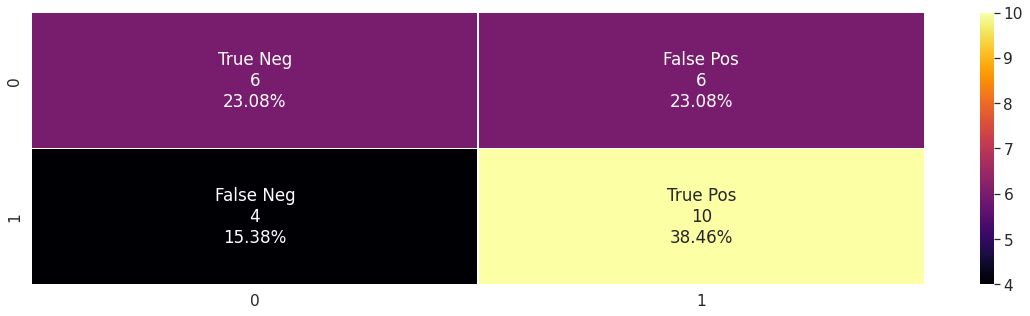

In [150]:
## train the model using the best estimator
pipe = model_rf.best_estimator_
model = pipe.fit(X_train, y_train)

## predictions
y_pred_rf = model.predict(X_test)

## HEATMAP-CONFUSION MATRIX
plt.figure(figsize=(20,5))
cf_matrix = confusion_matrix(y_test, y_pred_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='inferno',linewidths=0.3)

## metric scores on test set
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf): .4f}")
print(f"Precision score: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")

## classification report
clf_report = classification_report(y_test, y_pred_rf)

print(f"Classification Report : \n{clf_report}")

In [151]:
print(f'Accuracy: {round(accuracy_score(y_test, y_pred_rf),2)*100}%') ## correct predictions / total predictions

Accuracy: 62.0%


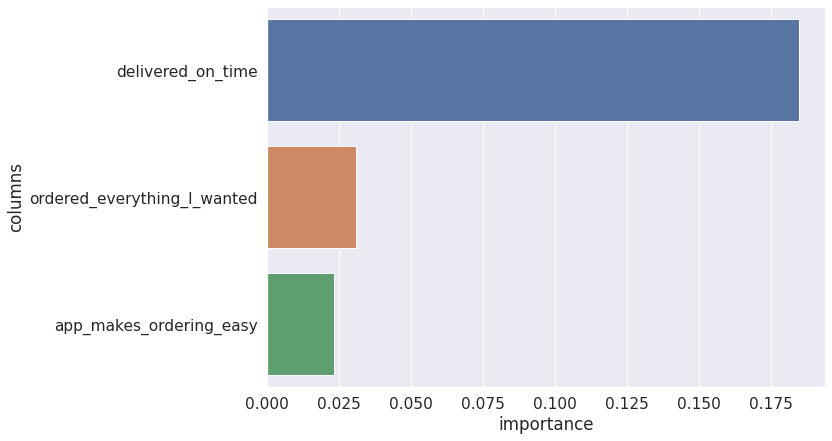

In [152]:
## We call permuation_importance and input the fitted model as model parameter
## We call it on test set, since it calculates the feature importance via its performance on our test set

result = permutation_importance(pipe, X_test, y_test, n_repeats=5, random_state=6, n_jobs=-1)

## plot the features against importance  
df = pd.DataFrame({'columns': X_test.columns, 'importance':result.importances_mean})
df = df.loc[df['importance']>0].sort_values(['importance'],ascending=False).reset_index()
plt.subplots(1,figsize=(10,7))
sns.barplot(x="importance",y="columns",data=df)
plt.show()

In [153]:
p = pd.DataFrame(columns=['Random_State','Accuracy'])
cols2drop = ['ordered_everything_I_wanted','paid_a_good_price','contents_as_expected','satisfied_with_my_courier','app_makes_ordering_easy']
data2 = data.copy()
data2.drop(cols2drop, axis=1, inplace=True)
for i in range(100):
   
    ## split the data frame into the response variable, y, and the design matrix, X
    df2 = data2.copy()
    y2 = df2['Happy'] ## response 
    X2 = df2.drop('Happy',axis=1) ## design matrix

    # split the data into training and test data sets
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, ## data-features to split
                                                        y2, ## data-response to split
                                                        test_size=0.2, ## we will leave 10% to test our models on later
                                                        random_state=i, ## make our work reproducible
                                                        #shuffle=True, ## prevent data ordering affecting our models
                                                        stratify=y2)

    ## Randomized Search Cross Validation

    pipe2 = Pipeline([("rf", RandomForestClassifier())])
    rscv2 = RandomizedSearchCV(estimator=pipe2,    ## estimator
                        param_distributions=rf_hyperparams, ## parameters to try
                        scoring = scoring_dict,  ## strategy to evaluate performance of the cross-validated model on the test set.
                        refit = "bal_acc_score", ## Refit an estimator using the best found parameters on the whole dataset.
                        n_jobs = -1,      ## Number of jobs to run in parallel, -1 means using all processors
                        random_state=i)  ## make our work reproducible)

    ## fit the training data
    model_rf2 = rscv2.fit(X_train2, y_train2)
    print(model_rf2.best_params_)

    ## train the model using the best estimator
    pipe2 = model_rf2.best_estimator_
    model2 = pipe2.fit(X_train2, y_train2)

    ## predictions
    y_pred_rf2 = model2.predict(X_test2)

    acc = round(accuracy_score(y_test2, y_pred_rf2),2)*100
    p = p.append({'Random_State': i, 'Accuracy' : acc}, ignore_index=True)

{'rf__n_estimators': 20, 'rf__min_samples_leaf': 8, 'rf__max_features': 'log2', 'rf__max_depth': 16, 'rf__criterion': 'gini', 'rf__bootstrap': True}
{'rf__n_estimators': 90, 'rf__min_samples_leaf': 9, 'rf__max_features': 'log2', 'rf__max_depth': 2, 'rf__criterion': 'gini', 'rf__bootstrap': True}
{'rf__n_estimators': 500, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 16, 'rf__criterion': 'gini', 'rf__bootstrap': True}
{'rf__n_estimators': 20, 'rf__min_samples_leaf': 7, 'rf__max_features': 'log2', 'rf__max_depth': 9, 'rf__criterion': 'entropy', 'rf__bootstrap': True}
{'rf__n_estimators': 50, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 50, 'rf__criterion': 'entropy', 'rf__bootstrap': True}
{'rf__n_estimators': 25, 'rf__min_samples_leaf': 3, 'rf__max_features': 'log2', 'rf__max_depth': 18, 'rf__criterion': 'gini', 'rf__bootstrap': True}
{'rf__n_estimators': 35, 'rf__min_samples_leaf': 9, 'rf__max_features': 'sqrt', 'rf__max_depth': 50, 

In [154]:
p.sort_values(by=['Accuracy'], ascending=False)[:5]

,Random_State,Accuracy
60,60.00,81.00
56,56.00,81.00
89,89.00,81.00
91,91.00,77.00
92,92.00,77.00


{'rf__n_estimators': 30, 'rf__min_samples_leaf': 9, 'rf__max_features': 'log2', 'rf__max_depth': 10, 'rf__criterion': 'entropy', 'rf__bootstrap': True}
Balanced accuracy score:  0.8214
Precision score: 0.8643
Recall score: 0.8077
Classification Report : 
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        12
           1       1.00      0.64      0.78        14

    accuracy                           0.81        26
   macro avg       0.85      0.82      0.81        26
weighted avg       0.86      0.81      0.80        26



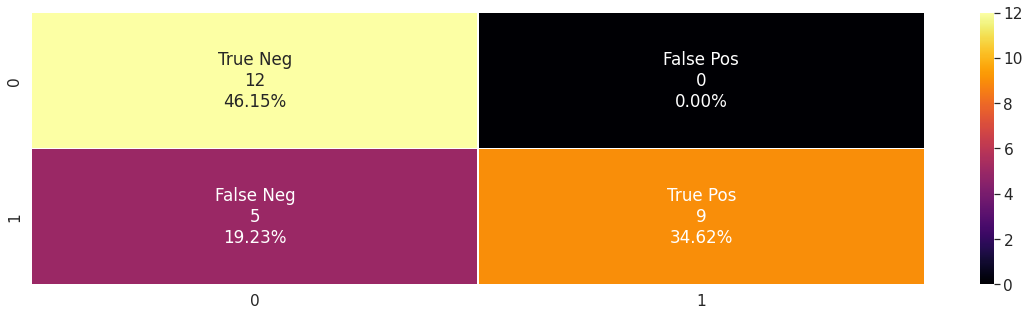

In [155]:
cols2drop = ['ordered_everything_I_wanted','paid_a_good_price','contents_as_expected','satisfied_with_my_courier','app_makes_ordering_easy']
data2 = data.copy()
data2.drop(cols2drop, axis=1, inplace=True)

## split the data frame into the response variable, y, and the design matrix, X
df2 = data2.copy()
y2 = df2['Happy'] ## response 
X2 = df2.drop('Happy',axis=1) ## design matrix

# split the data into training and test data sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, ## data-features to split
                                                    y2, ## data-response to split
                                                    test_size=0.2, ## we will leave 10% to test our models on later
                                                    random_state=89, ## make our work reproducible
                                                    #shuffle=True, ## prevent data ordering affecting our models
                                                    stratify=y2)

## Randomized Search Cross Validation

pipe2 = Pipeline([("rf", RandomForestClassifier())])
rscv2 = RandomizedSearchCV(estimator=pipe2,    ## estimator
                    param_distributions=rf_hyperparams, ## parameters to try
                    scoring = scoring_dict,  ## strategy to evaluate performance of the cross-validated model on the test set.
                    refit = "bal_acc_score", ## Refit an estimator using the best found parameters on the whole dataset.
                    n_jobs = -1,      ## Number of jobs to run in parallel, -1 means using all processors
                    random_state=89)  ## make our work reproducible)

## fit the training data
model_rf2 = rscv2.fit(X_train2, y_train2)
print(model_rf2.best_params_)

## train the model using the best estimator
pipe2 = model_rf2.best_estimator_
model2 = pipe2.fit(X_train2, y_train2)

## predictions
y_pred_rf2 = model2.predict(X_test2)

## HEATMAP-CONFUSION MATRIX
plt.figure(figsize=(20,5))
cf_matrix2 = confusion_matrix(y_test2, y_pred_rf2)
group_names2 = ['True Neg','False Pos','False Neg','True Pos']
group_counts2 = ['{0:0.0f}'.format(value) for value in
                cf_matrix2.flatten()]
group_percentages2 = ['{0:.2%}'.format(value) for value in
                     cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels2 = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names2,group_counts2,group_percentages2)]
labels2 = np.asarray(labels2).reshape(2,2)
sns.heatmap(cf_matrix2, annot=labels2, fmt='', cmap='inferno',linewidths=0.3)

## metric scores on test set
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test2, y_pred_rf2): .4f}")
print(f"Precision score: {precision_score(y_test2, y_pred_rf2, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test2, y_pred_rf2, average='weighted'):.4f}")

## classification report
clf_report2 = classification_report(y_test2, y_pred_rf2)

print(f"Classification Report : \n{clf_report2}")

In [156]:
print(f'Accuracy: {round(accuracy_score(y_test2, y_pred_rf2),2)*100}%') ## correct predictions / total predictions

Accuracy: 81.0%


**SHAP Analysis to better explain our machine learning model.**

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                        y, ## response to split
                                                        test_size=0.2, ## we will leave 20% to test our models on later. 
                                                        random_state=89, ## make our work reproducible
                                                       # shuffle=True,  ## prevent data ordering affecting our models
                                                        stratify = y)  ## same amount of ppl who are/are not happy in the training and test set

rf = DecisionTreeClassifier()
rf.fit(X_train,y_train)
explainer = shap.TreeExplainer(rf)

## Shap values are arrays of a length corresponding to the number of classes in target.
## Here, we have 2 classes.
shap_values = explainer.shap_values(X_test)

NOTE:
 - The Shapley value is the average contribution of a feature value to the prediction in different coalitions.
 - The Shapley value is NOT the difference in prediction when we would remove the feature from the model.

## Summary Plots

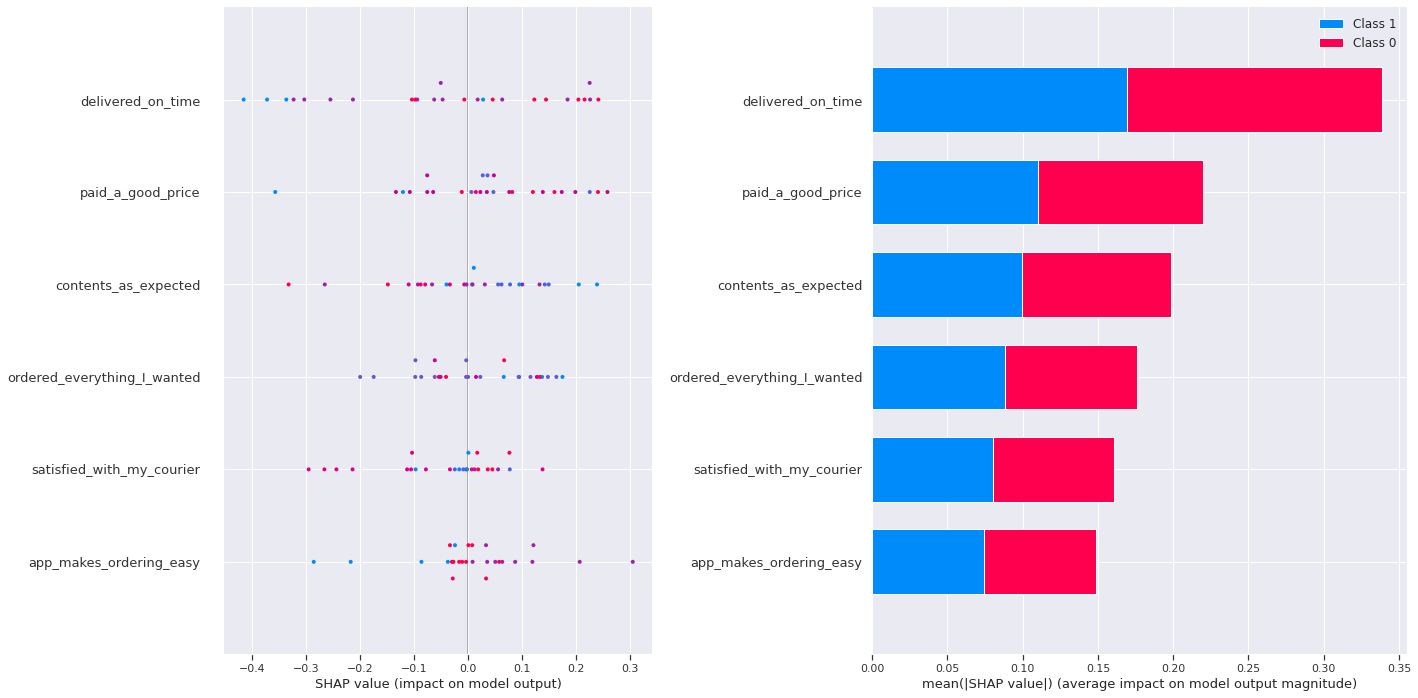

In [158]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
shap.summary_plot(shap_values[1], X_test, plot_size=None,show=False)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=None,show=False)
plt.tight_layout()
plt.show()

- All of the features are listed in y-axis in the rank order, the top one being the most contributor to the predictions and the bottom one being the least or zero-contributor. Shap values are provided in the x-axis.

- The summary plots indicate the 'delivered_on_time' feature as the one that contributes the most. This is in agreement with the feature importance method we used earlier.

## Force Plots

**Force plots** are suitable for row-wise SHAP analysis. It takes in a single row and shows in a rank order how each of the features contributed to the prediction. Wider a feature’s block, more the contribution.

- Red: Features that push the prediction to the base line.
- Blue: Features that pull the prediction lower from the base line.
- Red arrows represent feature effects (SHAP values) that drive the prediction value higher while blue arrows are those effects that drive the prediction value lower.

In [159]:
# # Initialize JavaScript visualizations in notebook environment
shap.initjs()
k = 3 ## controls which row to examine
print(f'The label for row {k} in the test set is: {y_test.iloc[k]}')
shap.force_plot(explainer.expected_value[1], shap_values[1][k], X_test.iloc[k])

The label for row 3 in the test set is: 0


## Dependence Plots

The feature importance plot is useful, but contains no information beyond the importances. For a more informative plot, we will next look at SHAP dependence plots.

Dependence plots can be of great use while analyzing feature importance and doing feature selection. It makes one-versus-one plot against two features by plotting shap values of one feature and coloring the dots with respect to another interactive feature.

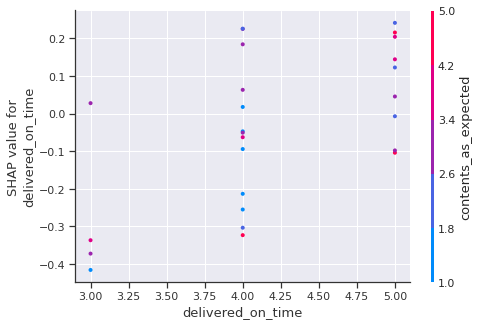

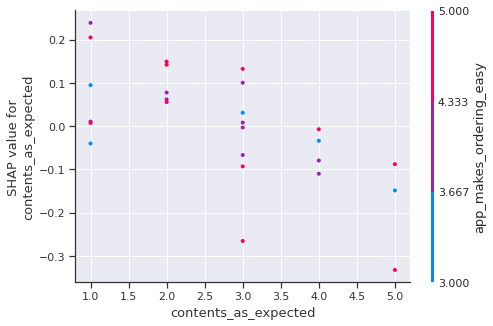

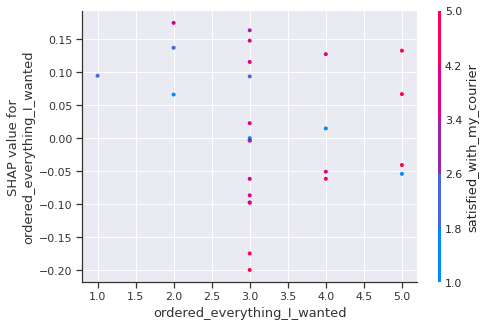

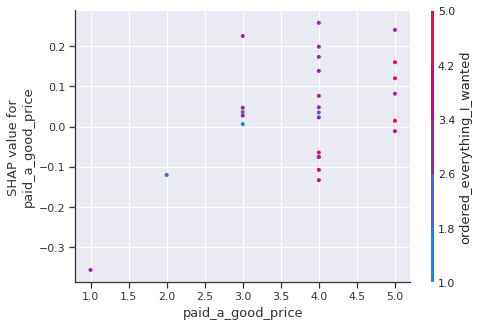

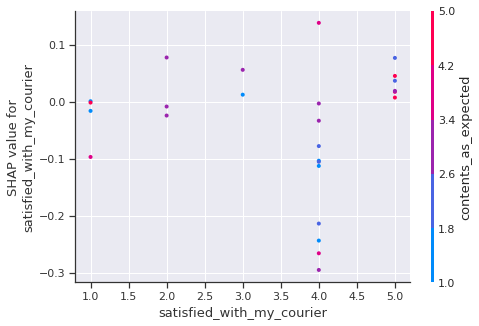

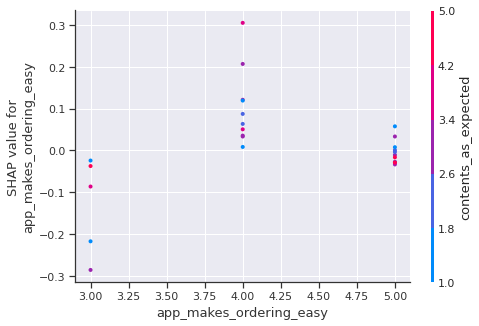

In [160]:
for i in range(6):
    shap.dependence_plot(i, shap_values[1], X_test)

## Decision Plot

As the summary plot, it gives an overall picture of contribution to prediction. From bottom to top of the decision plot, shap values are cumulatively added to the base value of the model in determining the output values. It can be observed that most strings colored in either blue or red resulted in the final class of value $0$ or $1$ respectively. However, there are $3$ strings that resulted at a model output value of $0.5$.

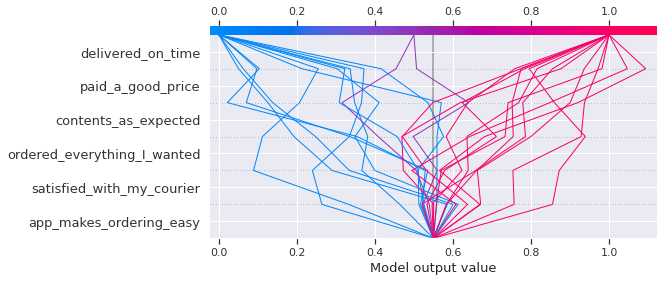

In [161]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test)

**Conclusion**

- Based on the $2$ feature importance methods we saw, 'delivered_on_time' is the most important feature and it is enough to achieve a model with an accuracy of $81$%. 
- We can reduce the number of questions asked during our survey down to just one. Doing so, we will save a lot of time and possibly get more people to participate in the survey.
- The company should focus on delivering its customers orders on time to keep them happy.